### Установка пакетов

In [1]:
!pip install -U ogb

     |████████████████████████████████| 71kB 3.4MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-cp37-none-any.whl size=7051 sha256=d5f9c8c4e0996e9cb9ac909c56e26a8ec72316956c465fe37e1d7d508a00db9b
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built littleutils


In [2]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 9.6MB/s 
     |████████████████████████████████| 1.5MB 10.5MB/s 
     |████████████████████████████████| 215kB 12.2MB/s 
     |████████████████████████████████| 235kB 20.8MB/s 
     |████████████████████████████████| 2.2MB 27.2MB/s 
     |████████████████████████████████| 51kB 3.5MB/s 


In [6]:
!pip install dgl-cu101

     |████████████████████████████████| 36.2MB 119kB/s 


In [7]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))

In [8]:
install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


### Загрузка данных

In [11]:
import rdkit
from ogb.lsc import PCQM4MDataset
from ogb.utils import smiles2graph

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [12]:
dataset = PCQM4MDataset(only_smiles = True)

# get i-th molecule and its target value (nan for test data)
i = 2000
print(dataset[i]) # ('O=C1C=CC(O1)C(c1ccccc1C)O', 5.292614392225)

Downloaded 0.06 GB: 100%|██████████| 59/59 [00:02<00:00, 24.62it/s]


Extracting dataset/pcqm4m_kddcup2021.zip
('COC(=O)C1=CN=CC(C1=O)N(=O)=O', 4.2096012672350005)


In [14]:
graph_obj = smiles2graph(dataset[i][0])

In [15]:
graph_obj['edge_index'].shape, graph_obj['edge_feat'].shape, graph_obj['node_feat'].shape 
#список смежных вершин, признаки связей, признаки атомов

((2, 28), (28, 3), (14, 9))

In [16]:
graph_obj['node_feat']

array([[5, 0, 4, 5, 3, 0, 2, 0, 0],
       [7, 0, 2, 5, 0, 0, 1, 0, 0],
       [5, 0, 3, 5, 0, 0, 1, 0, 0],
       [7, 0, 1, 5, 0, 0, 1, 0, 0],
       [5, 0, 3, 5, 0, 0, 1, 0, 1],
       [5, 0, 3, 5, 1, 0, 1, 0, 1],
       [6, 0, 2, 5, 0, 0, 1, 0, 1],
       [5, 0, 3, 5, 1, 0, 1, 0, 1],
       [5, 0, 4, 5, 1, 0, 2, 0, 1],
       [5, 0, 3, 5, 0, 0, 1, 0, 1],
       [7, 0, 1, 5, 0, 0, 1, 0, 0],
       [6, 0, 3, 6, 0, 0, 1, 0, 0],
       [7, 0, 1, 4, 0, 0, 1, 0, 0],
       [7, 0, 1, 5, 0, 0, 1, 0, 0]])

In [17]:
import torch 
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
atom_encoder = AtomEncoder(emb_dim = 20) # Pytorch Module class w/ learnable parameters
bond_encoder = BondEncoder(emb_dim = 20) # Pytorch Module class w/ learnable parameters

In [18]:
atom_emb = atom_encoder(torch.IntTensor(graph_obj['node_feat'])) # node_feat is input atom feature in Pytorch Tensor

In [19]:
edge_emb = bond_encoder(torch.IntTensor(graph_obj['edge_feat'])) # edge_feat is input edge feature in Pytorch Tensor

In [20]:
print(atom_emb.shape, edge_emb.shape)

torch.Size([14, 20]) torch.Size([28, 20])


In [21]:
split_dict = dataset.get_idx_split()
train_idx = split_dict['train'] # numpy array storing indices of training paper nodes
valid_idx = split_dict['valid'] # numpy array storing indices of validation paper nodes
test_idx = split_dict['test']

In [22]:
print(train_idx, valid_idx, test_idx)

[      0       1       2 ... 3045357 3045358 3045359] [3045360 3045361 3045362 ... 3426027 3426028 3426029] [3426030 3426031 3426032 ... 3803450 3803451 3803452]


In [23]:
dataset[train_idx[0]], dataset[valid_idx[1]], dataset[test_idx[0]]

(('Cc1ccc(cc1)C1C=c2cnccc2=NC1=O', 3.0476751256),
 ('Cn1nc(nc1C)c1ccccn1', 5.32254691578),
 ('COc1ccccc1N[C@@H](C(=NC(=N)O)O)C', nan))

In [24]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

In [25]:
element = smiles2graph(dataset[train_idx[0]][0])

In [26]:
m = Chem.MolFromSmiles(dataset[0][0])
mol_coords = AllChem.Compute2DCoords(m)

In [27]:
img = Draw.MolToImage(m)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [29]:
def plot_adjacency_matrix(element, ax):
    min_val, max_val = 0, element['edge_index'].shape[1] / 2

    ind_array = np.arange(min_val + 0.5, max_val + 0.5, 1.0)
    x, y = np.meshgrid(ind_array, ind_array)

    adjacency_matrix = np.zeros((int(element['edge_index'].shape[1] / 2), 
                                 int(element['edge_index'].shape[1] / 2)), dtype ='int')

    for edge_1, edge_2 in element['edge_index'].T:
        adjacency_matrix[edge_1, edge_2] = 1

    for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
        c = str(adjacency_matrix[int(x_val), int(y_val)])
        ax.text(x_val, y_val, c, va='center', ha='center')

    ax.set_aspect('equal', adjustable='box')
        
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.grid()

In [30]:
def plot_batch_samples(batch):
    fig = plt.figure(figsize = (12, 15))
    axes = fig.subplots(nrows=3, ncols=2)

    plt.subplots_adjust(wspace = 0.05, hspace = 0.2)
    
    for i, (smile, y) in enumerate(batch):
        graph = smiles2graph(smile)
        mol = Chem.MolFromSmiles(smile)
        img = Draw.MolToImage(mol)
        
        axes[i, 0].set_title('Target: ' + str(y))
        axes[i, 0].imshow(img)
        plot_adjacency_matrix(graph, axes[i, 1])
        axes[i, 1].set_title('Adjacency_matrix')
        if i == 2:
            break

    plt.show()

In [31]:
batch = [dataset[0], dataset[1], dataset[2]]

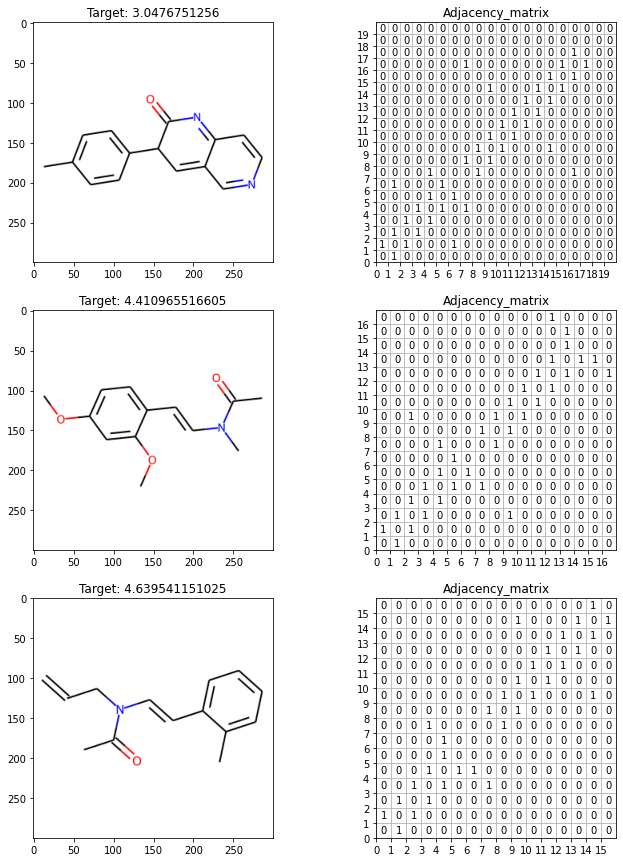

In [32]:
plot_batch_samples(batch)

In [34]:
import torch_geometric
import dgl

In [36]:
from ogb.lsc import PygPCQM4MDataset
pyg_dataset = PygPCQM4MDataset(root = 'py_geom_dataset', smiles2graph = smiles2graph)

Downloaded 0.06 GB: 100%|██████████| 59/59 [00:02<00:00, 23.44it/s]


Extracting py_geom_dataset/pcqm4m_kddcup2021.zip
Processing...


  0%|          | 42/3803453 [00:00<2:32:23, 415.99it/s]

Converting SMILES strings into graphs...


  1%|          | 42747/3803453 [01:38<2:23:43, 436.09it/s]

KeyboardInterrupt: ignored